# FCNN versus CNN
This notebook is primarily concerned with recreating Figure 1 in **Why Are Convolutional Networks More Sample Efficient Than Fully-Connected Nets?** by Zhiyuan Li, Yi Zhang and Sanjeev Arora [1]. We have two lines of thought about this figure.

1. We wish to verify that the graphs are authentic and clarify their methods.
2. We believe that the graphs don't reflect the sample-complexity gap claimed in the abstract.

This notebook will address point 1.

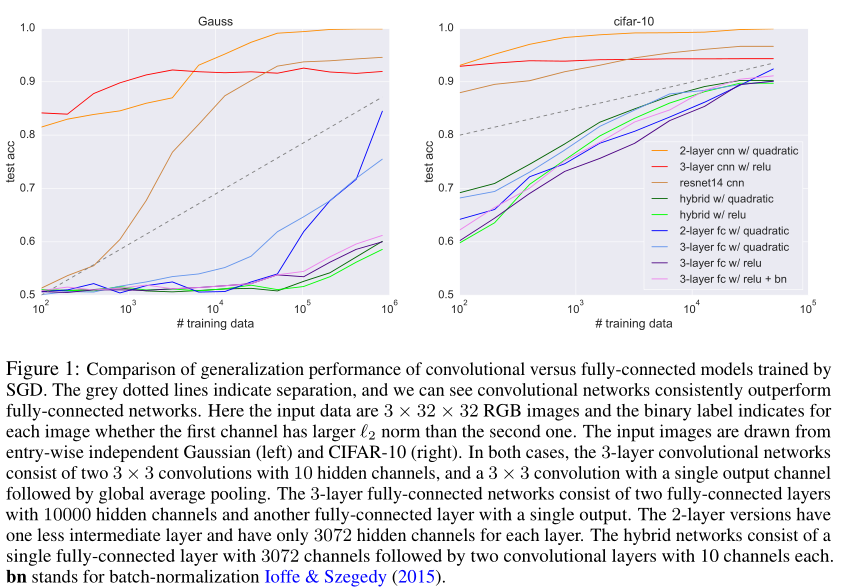

## 1. Methods

The original paper somewhat underspecifies their methods, so we mark in **bold** our assumptions and intepretations.

### Data

The inputs are $3\times8\times8$ RGB images. We will use training sets of increasing sizes from $10^2$ to $10^6$ and **test sets of size 10'000**. The training sets are constructed in the following manner.

+ Entry-wise independent Gaussian (mean 0, standard deviation 1)

The labels are binary, indicating whether the Red channel has larger $l_2$-norm than the Green channel. Mathematically, the label of an image $x$ is $\mathbb{1}[\sum_{i\in R}x_i^2 > \sum_{i\in G}x_i^2]$. As such, the Blue channel has no effect on the true label. 

### Models
1. 2-layer CNN
    + Convolution: One kernel per input channel of size 3x3, 10 output channels, stride size 1, and padding of 1, and bias
    + Activation function
    + Max pooling, kernel size 2x2, stride 2
    + Fully connected layer (160 in, 1 out) with bias
    + Sigmoid  
2. 2-layer "Dumb" CNN. (DCNN)
    + Convolution: One kernel per input channel of size 3x3, 2 output channels, stride size 1, and padding of 0, and bias
    + Activation function
    + Global average pooling, kernel size 8x8
    + Fully connected layer (160 in, 1 out) with bias
    + Sigmoid
2. 2-layer FCNN 
    + Fully connected layer (192 in, 3072 out) with bias
    + Activation function 
    + Fully connected layer (3072 in, 1 out) with bias
    + Sigmoid
    
For both models, we try both ReLU and Quadratic activation functions (in the convolutional, and hidden layer respectively). 
    
### Training algorithm
+ Stochastic Gradient Descent **with batch size 64**
+ The loss function is **BCELoss**
+ The **learning rate** is $\gamma = 0.01$
+ Training **stops** when **at least 10 epochs** have transpired and **training loss < 0.01** and **the rolling average of relative change in training loss < 0.01** with **window size 10**. It also stops after some maximum number of epochs.

### Model Evaluation
+ The model $M$ prediction is $\mathbb{1}[M(x)>0.5]$. Test accuracy is the percentage of correct predictions over the test set.

## 2. Experiment

In [6]:
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
ipython = get_ipython()

# New cell magic to use python variables in cell magic
@register_cell_magic
def format(line, cell):
    magic, program = line.split(' ')
    ipython.run_cell_magic(magic, program, cell.format(**globals()))

In [12]:
# Experiment variables
splits          = 2 # Training set size splits between 10**min and 10**max
max_epochs      = 100 # Maximum number of training epochs per split
norm            = 2 # Labelling function parameter
width           = 6 # Length of square image side
delete_results  = False # Delete results of previous runs for that parameter set (all models).
filepath        = 'results/week1/p'+str(norm)+'_l'+str(width)+'_e'+str(max_epochs)+'.pkl' # Results file

In [13]:
%%format script powershell
python tr_size_vs_te_acc.py -actv "Quad" -arch "DumbCNN" -min 2 -max 4 -f {filepath} -s {splits} -e {max_epochs} -p {norm} -l {width} -del {delete_results}

Windows PowerShell
Copyright (C) Microsoft Corporation. All rights reserved.

Try the new cross-platform PowerShell https://aka.ms/pscore6

PS C:\Users\oilio\Documents\School Documents\EPFL\MA3\Semester Project\Tasks> python tr_size_vs_te_acc.py -actv "Quad" -arch "DumbCNN" -min 2 -max 4 -f results/week1/p2_l6_e100.pkl -s 2 -e 100 -p 2 -l 6 -del False
Using device:  cpu 

Progress: |**************************************************| 100.0% Complete
PS C:\Users\oilio\Documents\School Documents\EPFL\MA3\Semester Project\Tasks> 

## 3. Results

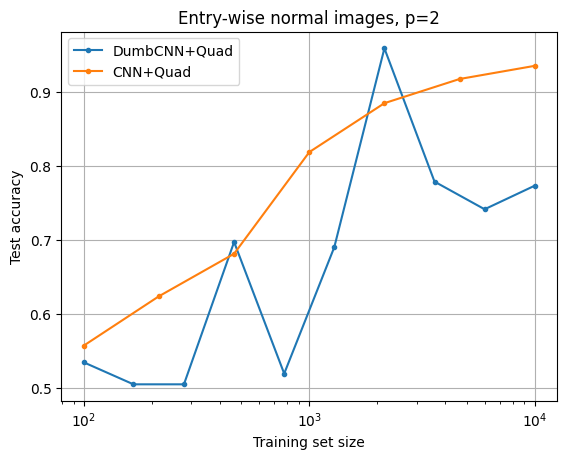

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load data
with open(filepath, 'rb') as file:
    test_acc = pickle.load(file)

# Extract data to plot
names = set([name for name, _ in test_acc.keys()])

# For every model, make line plot
for name in names:
    x, y = list(zip(*sorted([(tr_size, te_acc) for (_name, tr_size), te_acc  in test_acc.items() if name == _name])))
    plt.semilogx(x, y, marker='.', linestyle='-', label=name)

# Plot graphics
plt.xlabel('Training set size')
plt.ylabel('Test accuracy')
plt.title('Entry-wise normal images, p={:d}'.format(norm))
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## References
1. [Why Are Convolutional Nets More Sample-Efficient than Fully-Connected Nets?](https://arxiv.org/abs/2010.08515) Zhiyuan Li, Yi Zhang, Sanjeev Arora, 2021
2. [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.